In [1]:
import scanpy as sc
import scFates as scf
sc.set_figure_params()

In [2]:
adata=sc.read("data/adata_raw.h5ad")

## Basic filtering of low quality cells

In [3]:
adata.var["ERCC"]=adata.var_names.str.startswith("ERCC")

In [4]:
sc.pp.calculate_qc_metrics(adata,qc_vars=["ERCC"], percent_top=None, log1p=False, inplace=True)

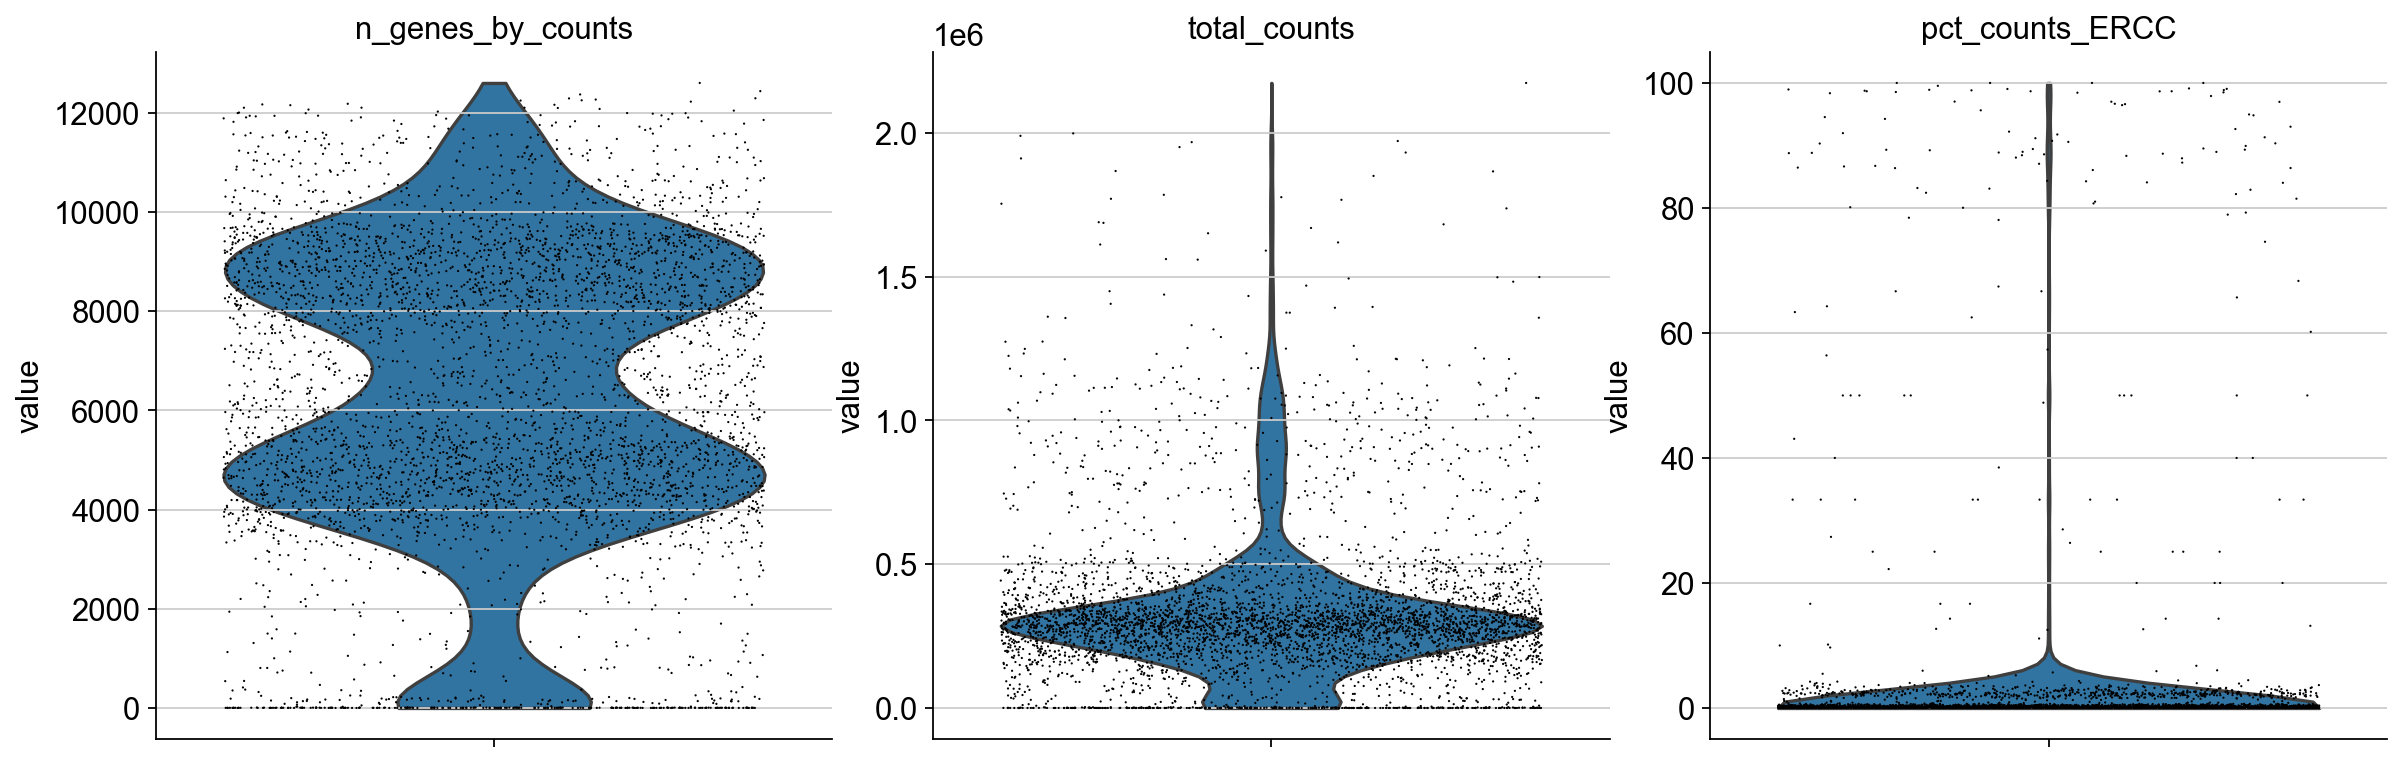

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_ERCC'],
             jitter=0.4, multi_panel=True)
adata = adata[(adata.obs.n_genes_by_counts > 1000) & (adata.obs.pct_counts_ERCC < 5), :]

In [6]:
adata=adata[:,~adata.var.ERCC]

## Per-developmental time analysis

In [7]:
def p_dev(dev):
    ldata=adata[adata.obs.devtime==dev].copy()
    ldata.var_names_make_unique()

    sc.pp.filter_genes(ldata,min_cells=3)
    sc.pp.normalize_total(ldata, target_sum=1e4)
    sc.pp.log1p(ldata)
    scf.pp.find_overdispersed(ldata)
    ldata.layers["scaled"]=sc.pp.scale(ldata.X,max_value=10,copy=True)
    ldata.obsm["X_pca"]=sc.pp.pca(ldata[:,ldata.var.highly_variable].layers["scaled"])
    sc.pp.neighbors(ldata,n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(ldata)
    sc.tl.leiden(ldata)
    return ldata

In [8]:
from scFates.tools.utils import ProgressParallel
from joblib import delayed

In [9]:
adata.obs.devtime.cat.categories

Index(['E14.5', 'E15.5', 'E16.5', 'E17.5', 'E18.5', 'P3'], dtype='object')

In [10]:
ldatas=ProgressParallel(total=len(adata.obs.devtime.cat.categories),
                        n_jobs=len(adata.obs.devtime.cat.categories))(
    delayed(p_dev)(dev) for dev in adata.obs.devtime.cat.categories
)

100%|██████████| 6/6 [00:35<00:00,  5.95s/it]


In [11]:
adatas=dict(zip(adata.obs.devtime.cat.categories,ldatas))

## Identification of glial contaminated cells

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'glial_conta' as categorical


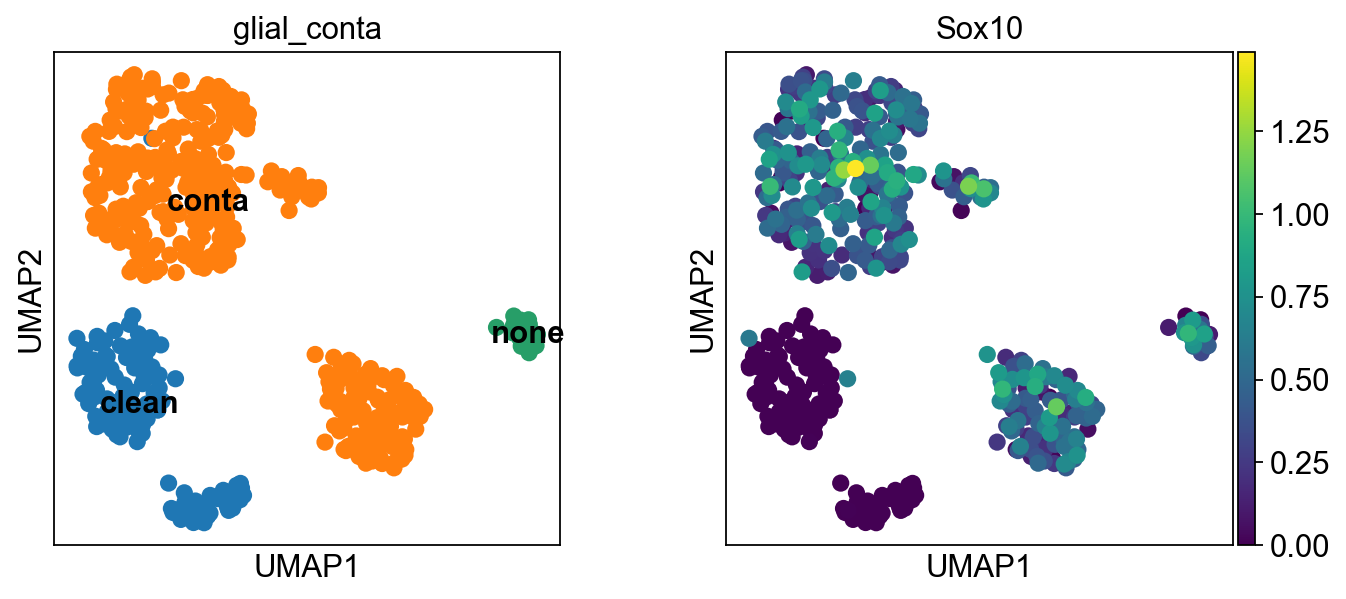

In [12]:
adatas["P3"].obs["glial_conta"]="none"

adatas["P3"].obs.loc[adatas["P3"].obs["leiden"].isin(["1","5"]),"glial_conta"]="clean"
adatas["P3"].obs.loc[adatas["P3"].obs["leiden"].isin(["0","2","3","4","7"]),"glial_conta"]="conta"

sc.pl.umap(adatas["P3"],color=["glial_conta","Sox10"],legend_loc="on data")

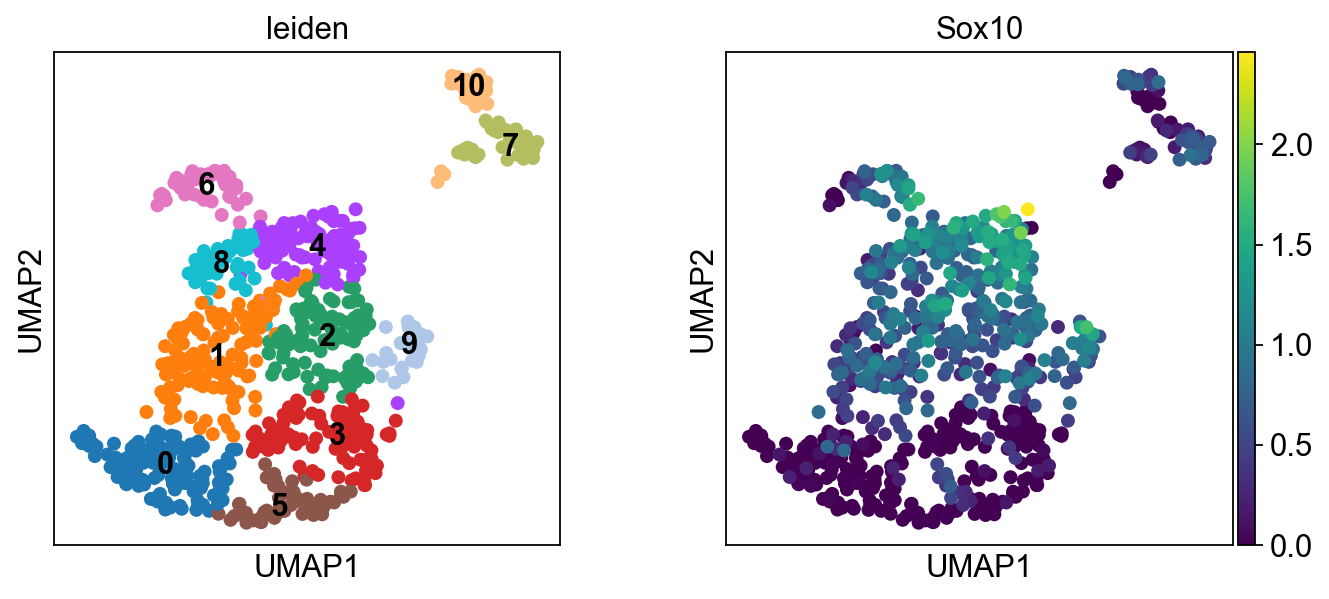

In [13]:
sc.set_figure_params()
sc.pl.umap(adatas["E18.5"],color=["leiden","Sox10"],legend_loc="on data")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'glial_conta' as categorical


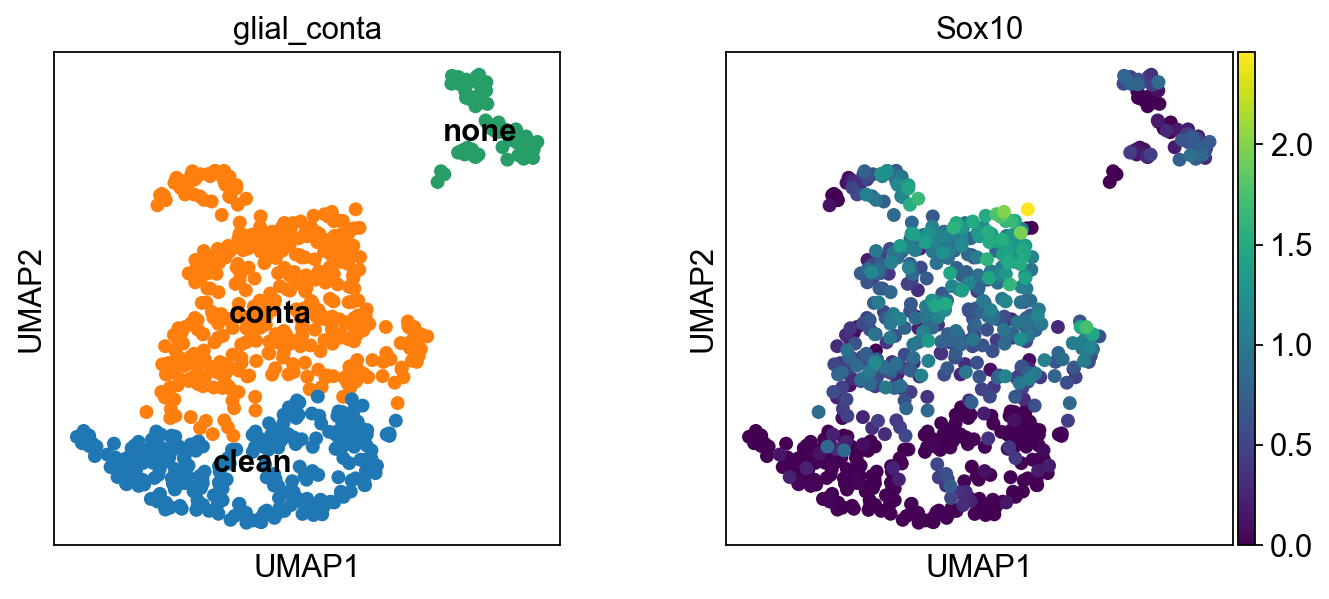

In [14]:
adatas["E18.5"].obs["glial_conta"]="none"

adatas["E18.5"].obs.loc[adatas["E18.5"].obs["leiden"].isin(["0","3","5"]),"glial_conta"]="clean"
adatas["E18.5"].obs.loc[adatas["E18.5"].obs["leiden"].isin(["1","4","2","9","6","8"]),"glial_conta"]="conta"

sc.pl.umap(adatas["E18.5"],color=["glial_conta","Sox10"],legend_loc="on data")

In [15]:
adatas["E18.5"].obs.glial_conta.value_counts()

conta    420
clean    271
none      71
Name: glial_conta, dtype: int64

In [16]:
adatas["P3"].obs.glial_conta.value_counts()

conta    358
clean    122
none      21
Name: glial_conta, dtype: int64

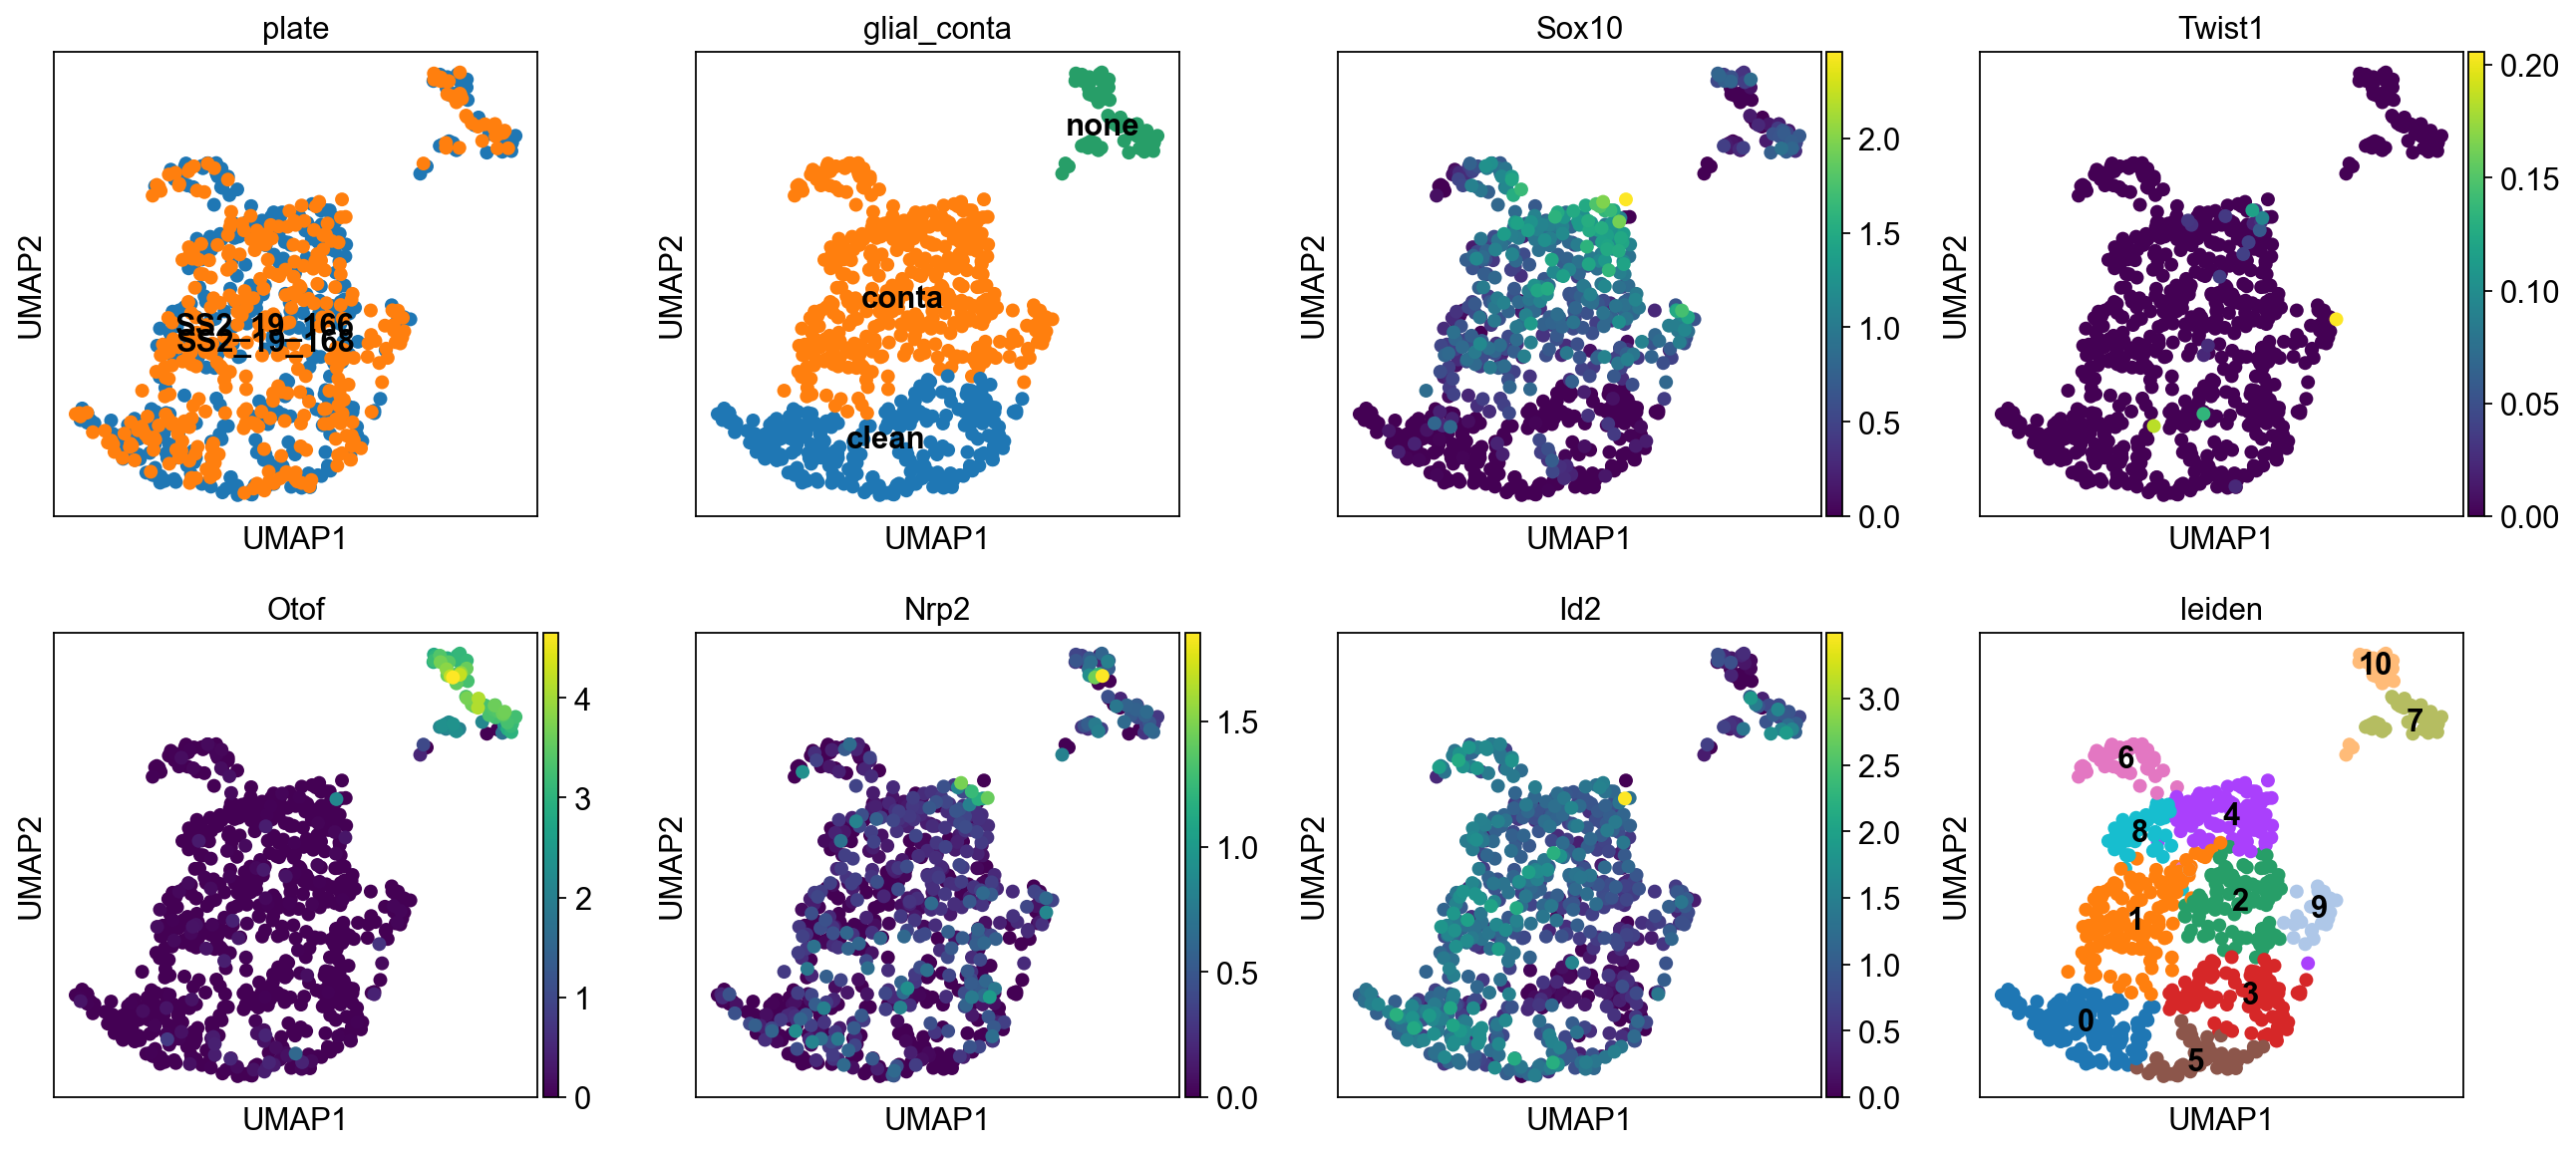

In [17]:
sc.pl.umap(adatas["E18.5"],color=["plate","glial_conta","Sox10","Twist1","Otof","Nrp2","Id2","leiden"],legend_loc="on data")

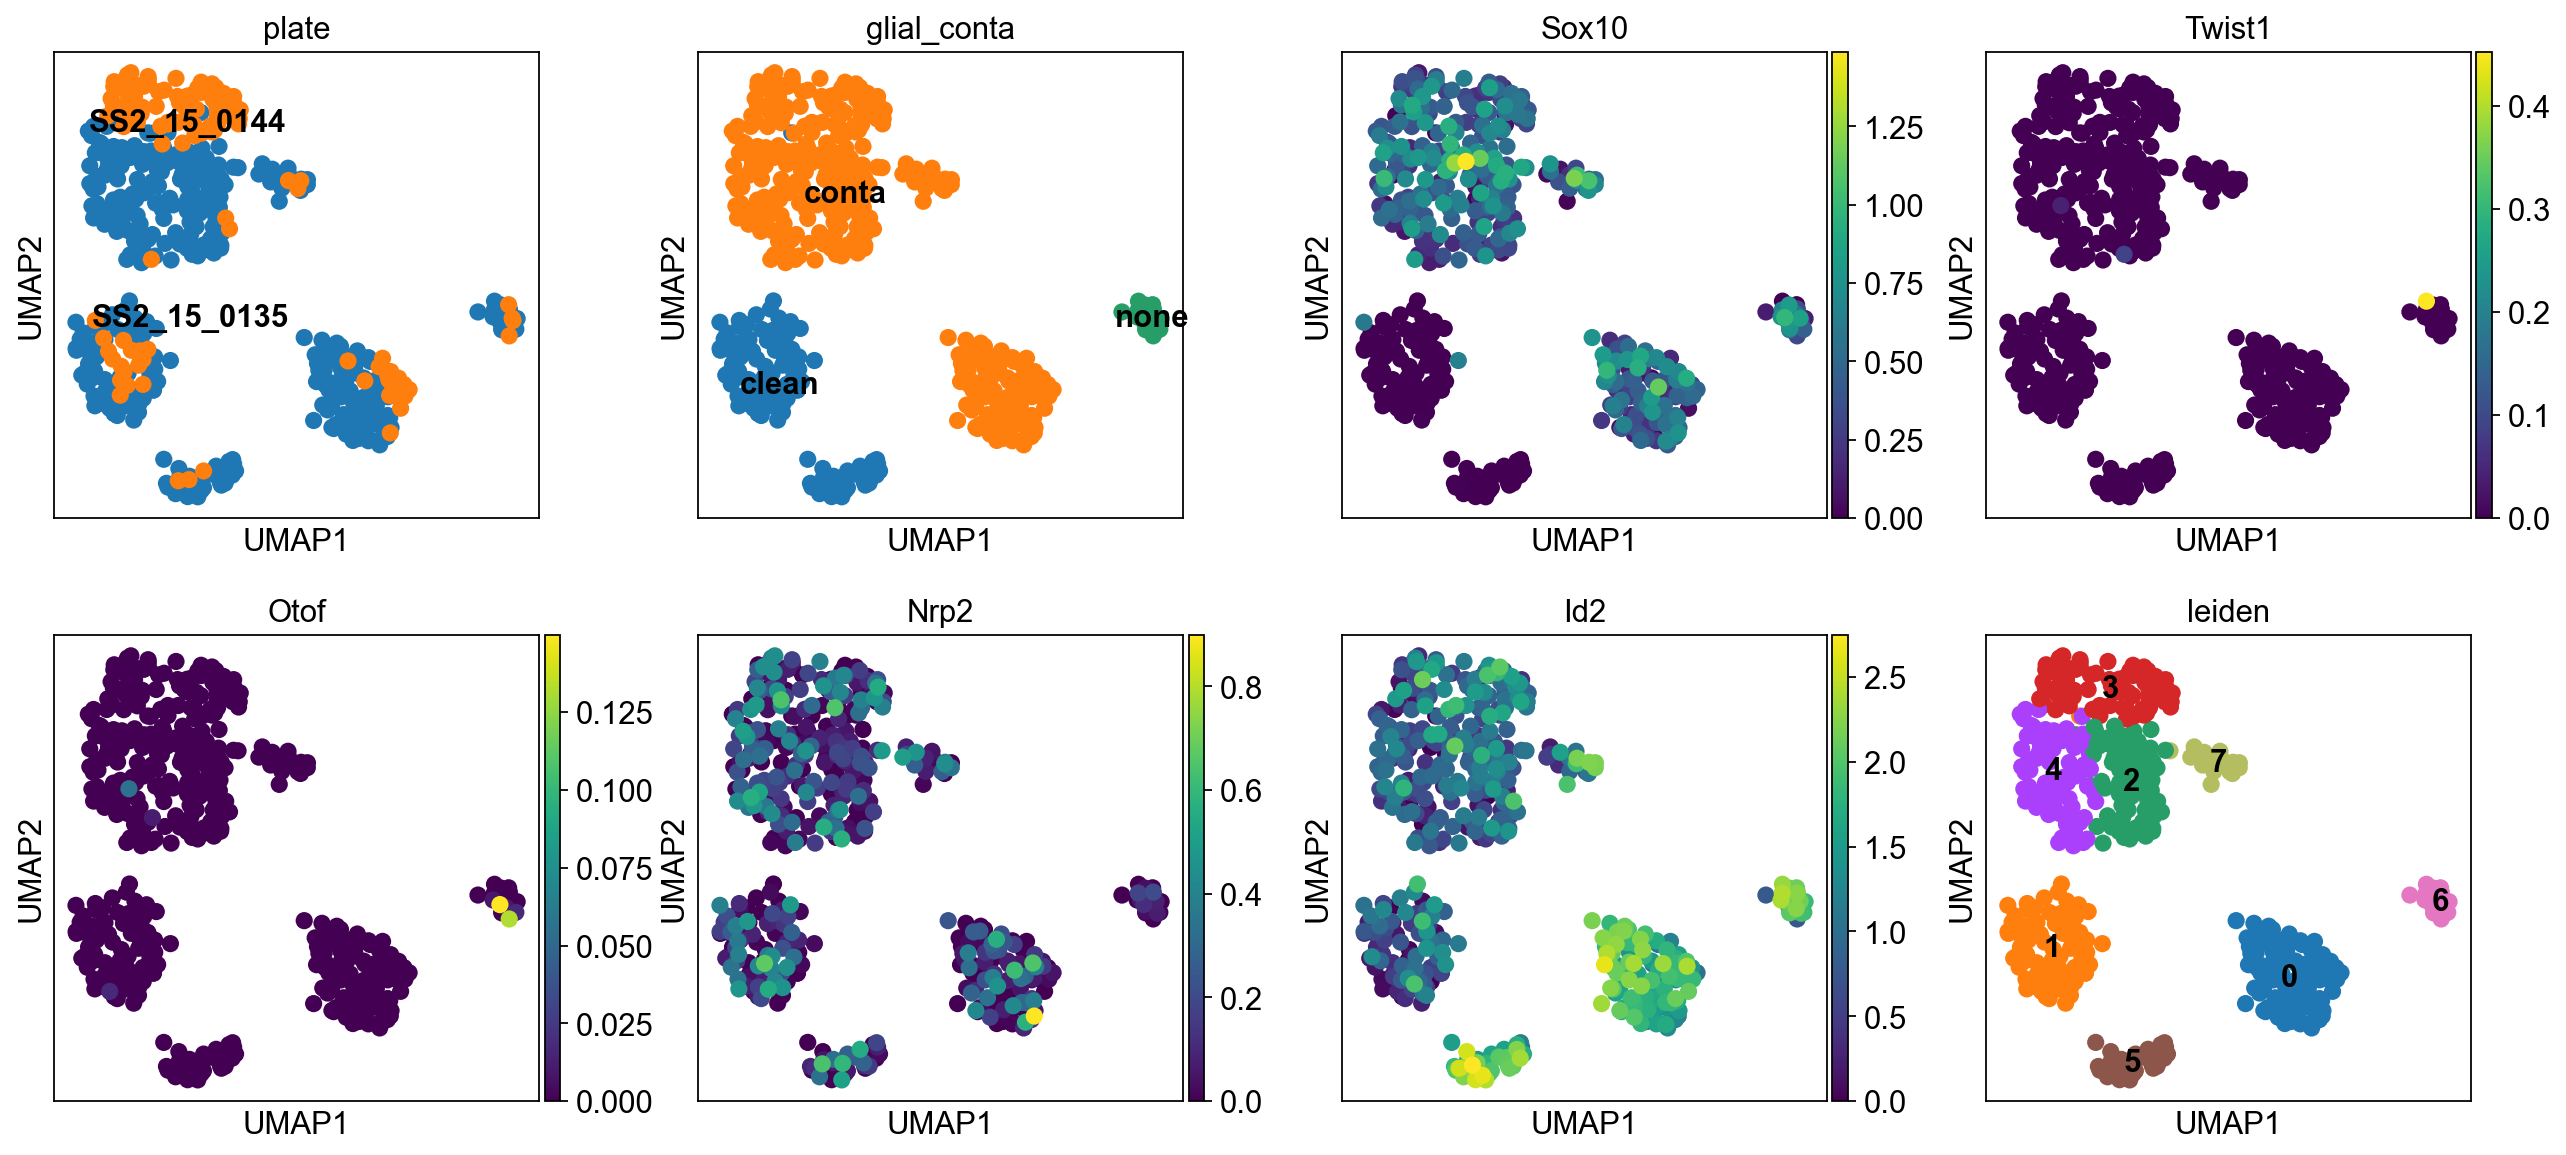

In [18]:
sc.pl.umap(adatas["P3"],color=["plate","glial_conta","Sox10","Twist1","Otof","Nrp2","Id2","leiden"],legend_loc="on data")

## Removing glial code using Sox10

In [19]:
from scFates.tools.utils import cor_mat_gpu
import cupy as cp
mat=cp.asarray(adatas["E18.5"].X.A)
cormat=cor_mat_gpu(mat,mat)
cormat=cormat.get()

In [20]:
import pandas as pd
sox10=pd.DataFrame(cormat,index=adatas["E18.5"].var_names,columns=adatas["E18.5"].var_names).loc["Sox10"].sort_values(ascending=False)

(array([4.5000e+01, 5.1300e+02, 3.1200e+03, 1.0496e+04, 2.9990e+03,
        1.0940e+03, 5.0100e+02, 2.3000e+02, 1.1100e+02, 3.0000e+00]),
 array([-0.52946705, -0.3765202 , -0.22357333, -0.07062647,  0.08232039,
         0.23526725,  0.3882141 ,  0.54116094,  0.69410783,  0.8470547 ,
         1.0000015 ], dtype=float32),
 <BarContainer object of 10 artists>)

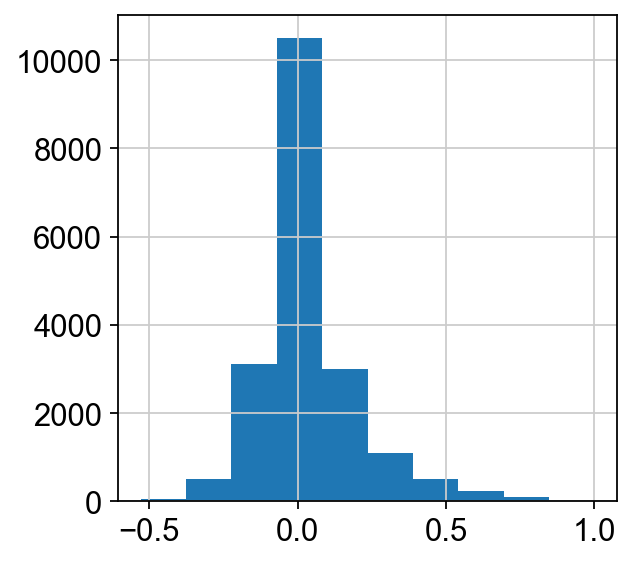

In [21]:
import matplotlib.pyplot as plt
plt.hist(sox10)

## Process E18.5 and P3 without glial code

In [22]:
def run_clean(glial_code):
    scf.pp.find_overdispersed(adatas["E18.5"])
    adatas["E18.5"].var.loc[glial_code,"highly_variable"]=False
    adatas["E18.5"].obsm["X_pca"]=sc.pp.pca(adatas["E18.5"][:,adatas["E18.5"].var.highly_variable].layers["scaled"])
    sc.pp.neighbors(adatas["E18.5"],n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(adatas["E18.5"])
    sc.tl.leiden(adatas["E18.5"],key_added="leiden2")
    
    scf.pp.find_overdispersed(adatas["P3"])
    adatas["P3"].var.loc[adatas["P3"].var_names[adatas["P3"].var_names.isin(glial_code)],"highly_variable"]=False
    adatas["P3"].obsm["X_pca"]=sc.pp.pca(adatas["P3"][:,adatas["P3"].var.highly_variable].layers["scaled"])
    sc.pp.neighbors(adatas["P3"],n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(adatas["P3"])
    sc.tl.leiden(adatas["P3"])
    
    sc.pl.umap(adatas["E18.5"],color=["glial_conta","Sox10","leiden2"],legend_loc="on data")
    sc.pl.umap(adatas["P3"],color=["glial_conta","Sox10","leiden"],legend_loc="on data")

In [23]:
glial_code=sox10.index[(sox10>.3)]
len(glial_code)

1371

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3256 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2898 over-dispersed features (0:00:00) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



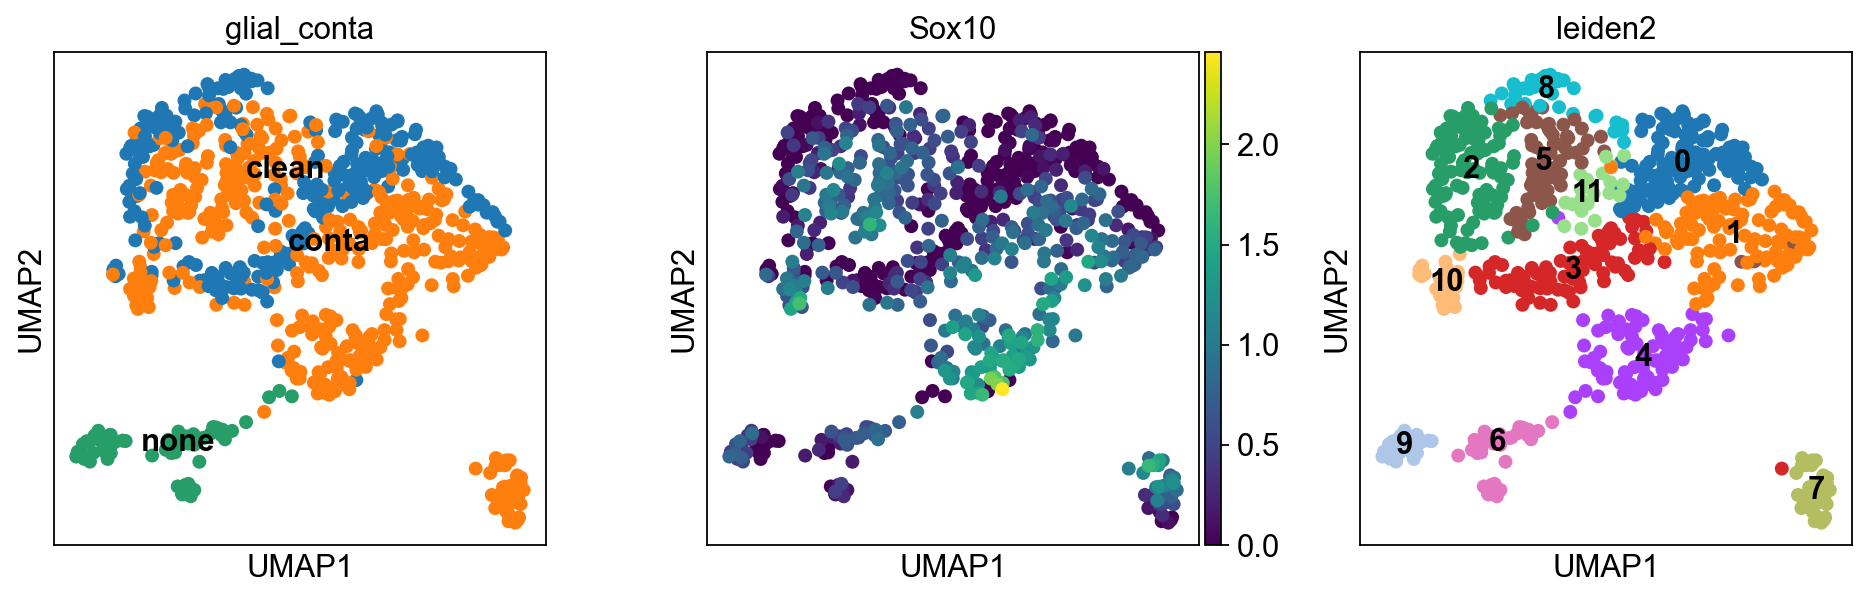

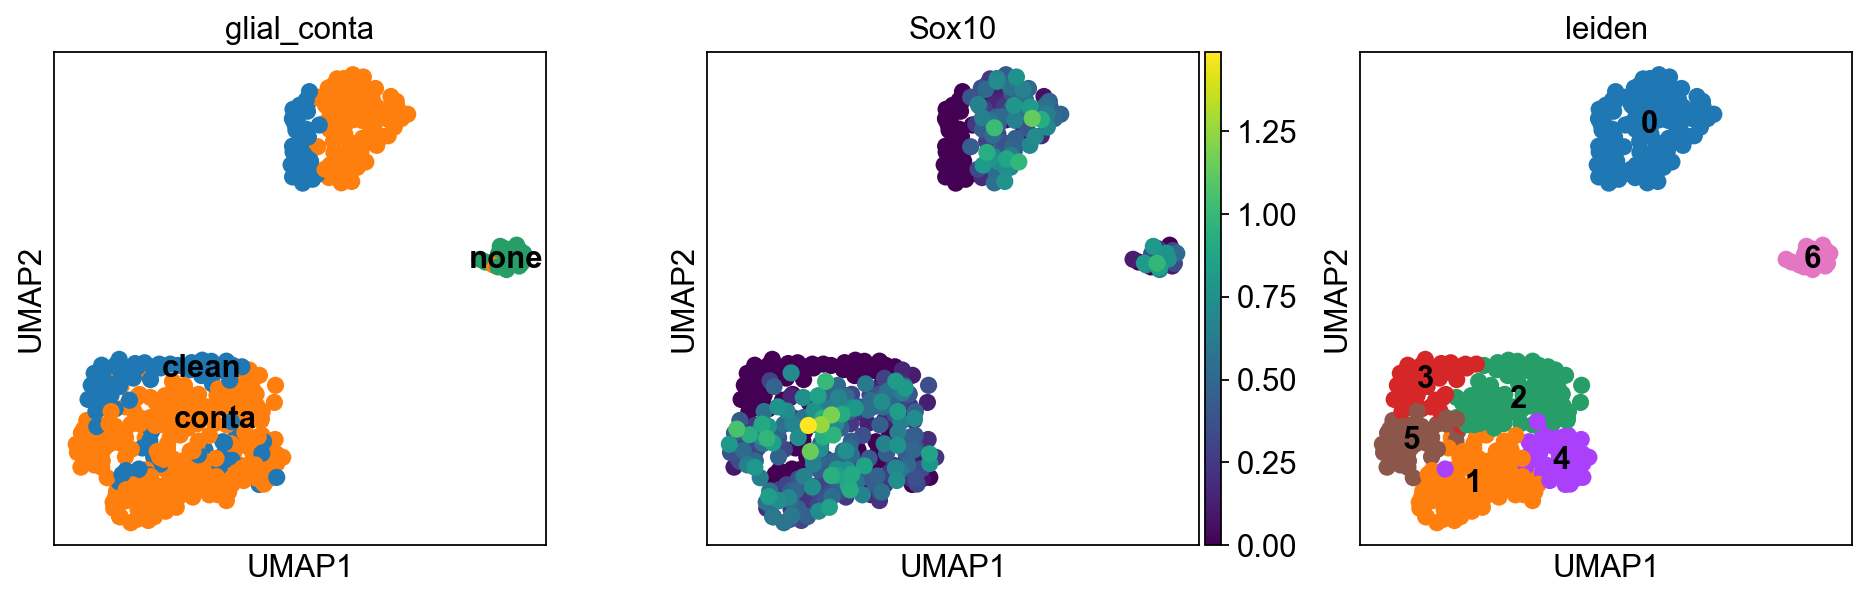

In [24]:
run_clean(glial_code)

## Further subsetting of other developmental timepoints

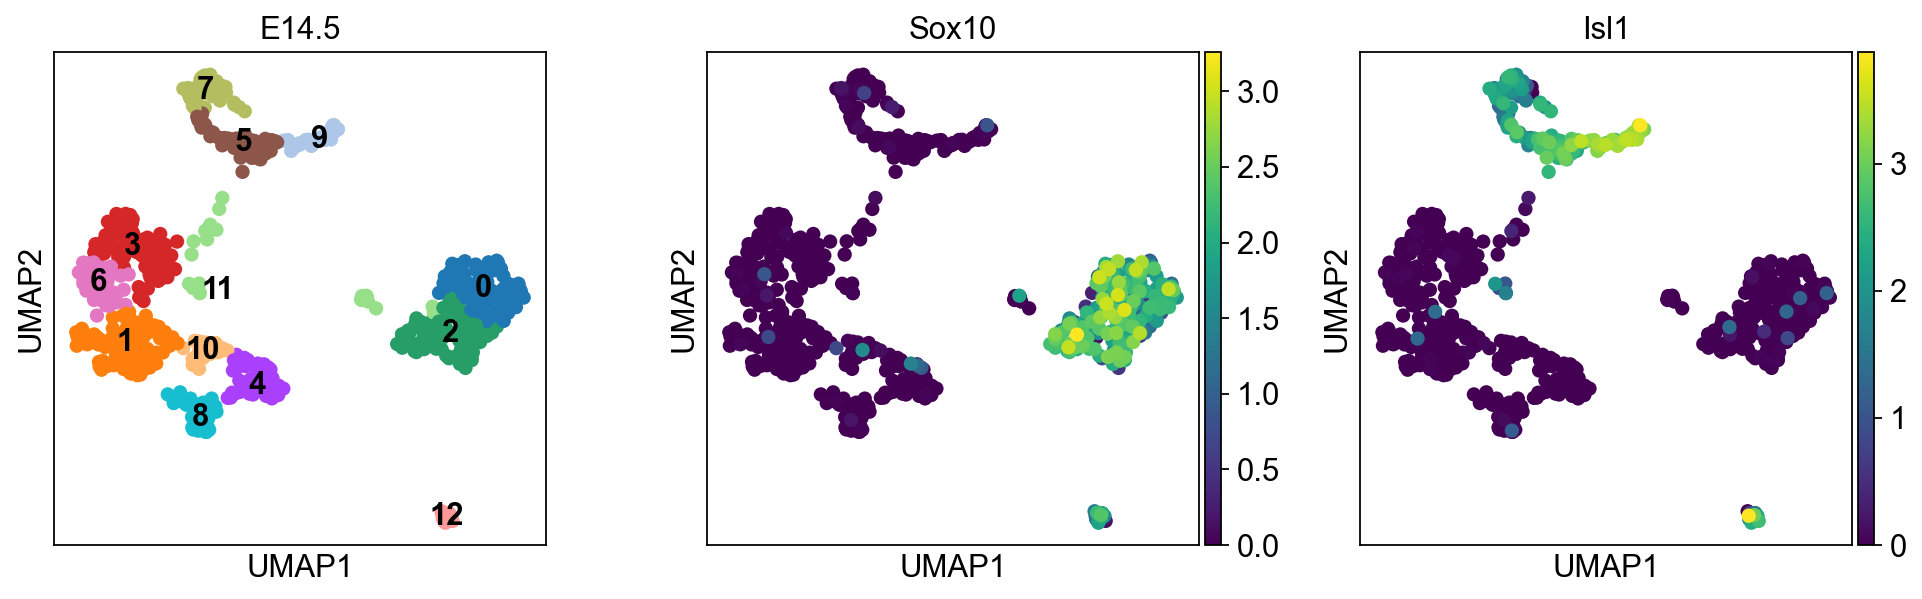

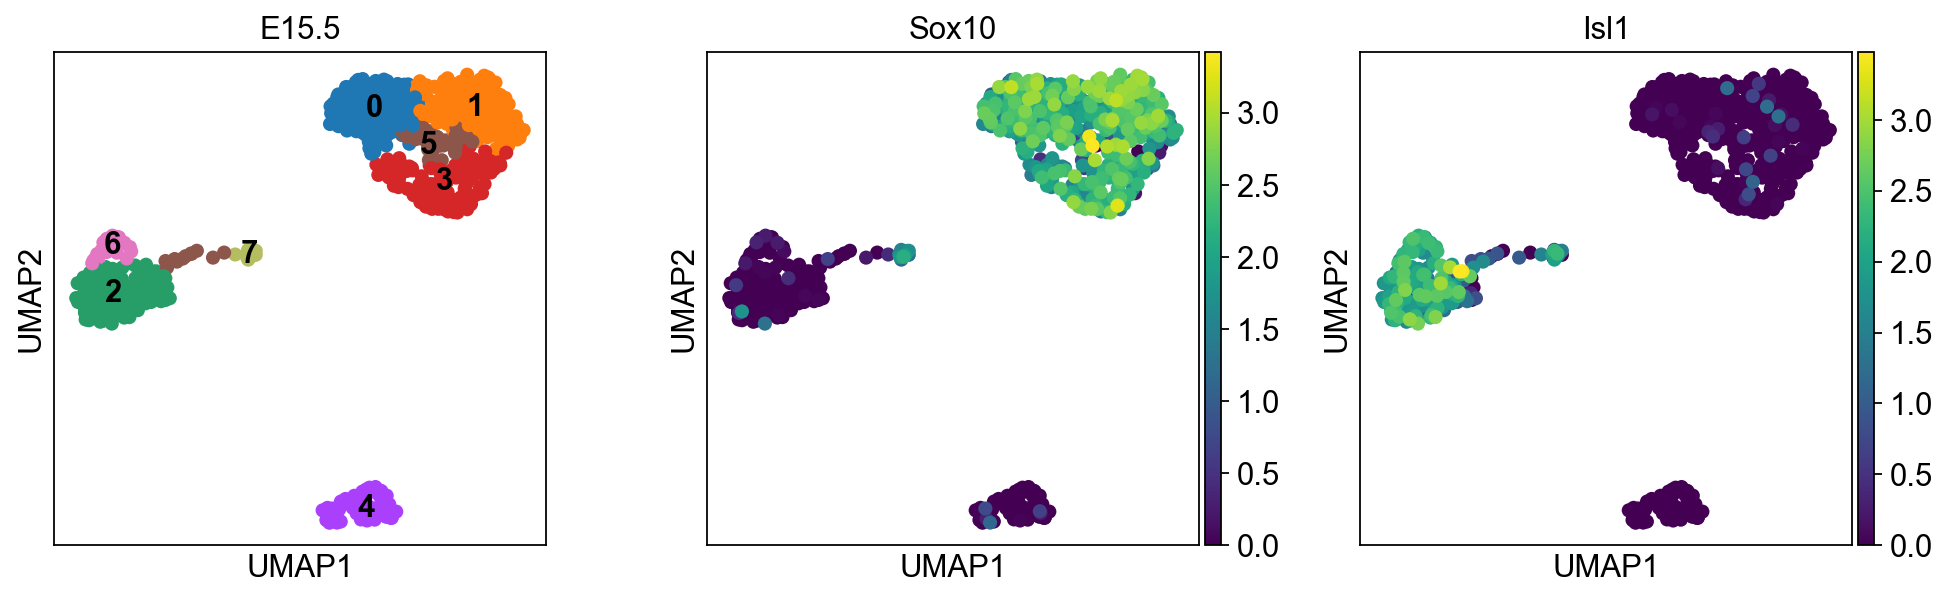

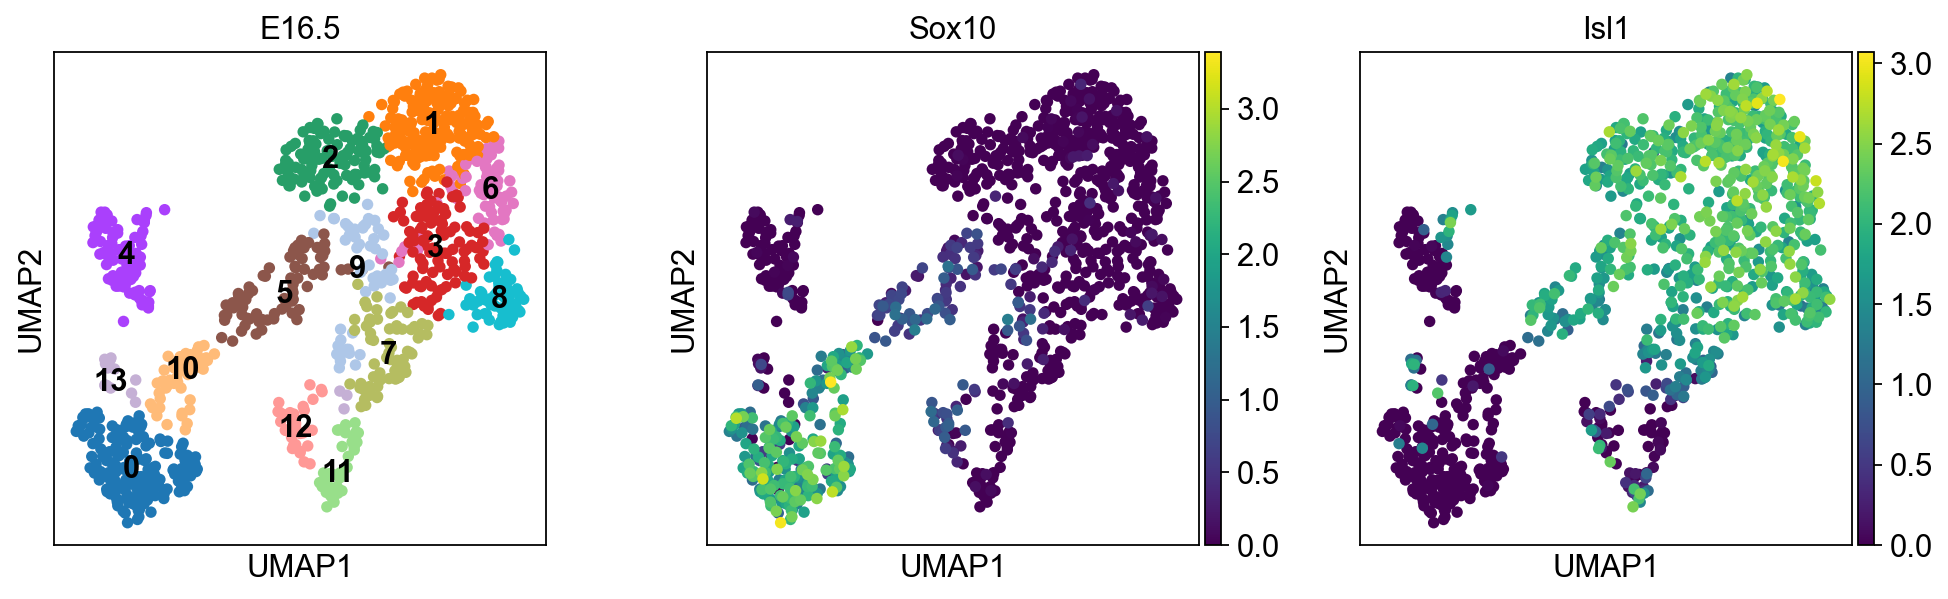

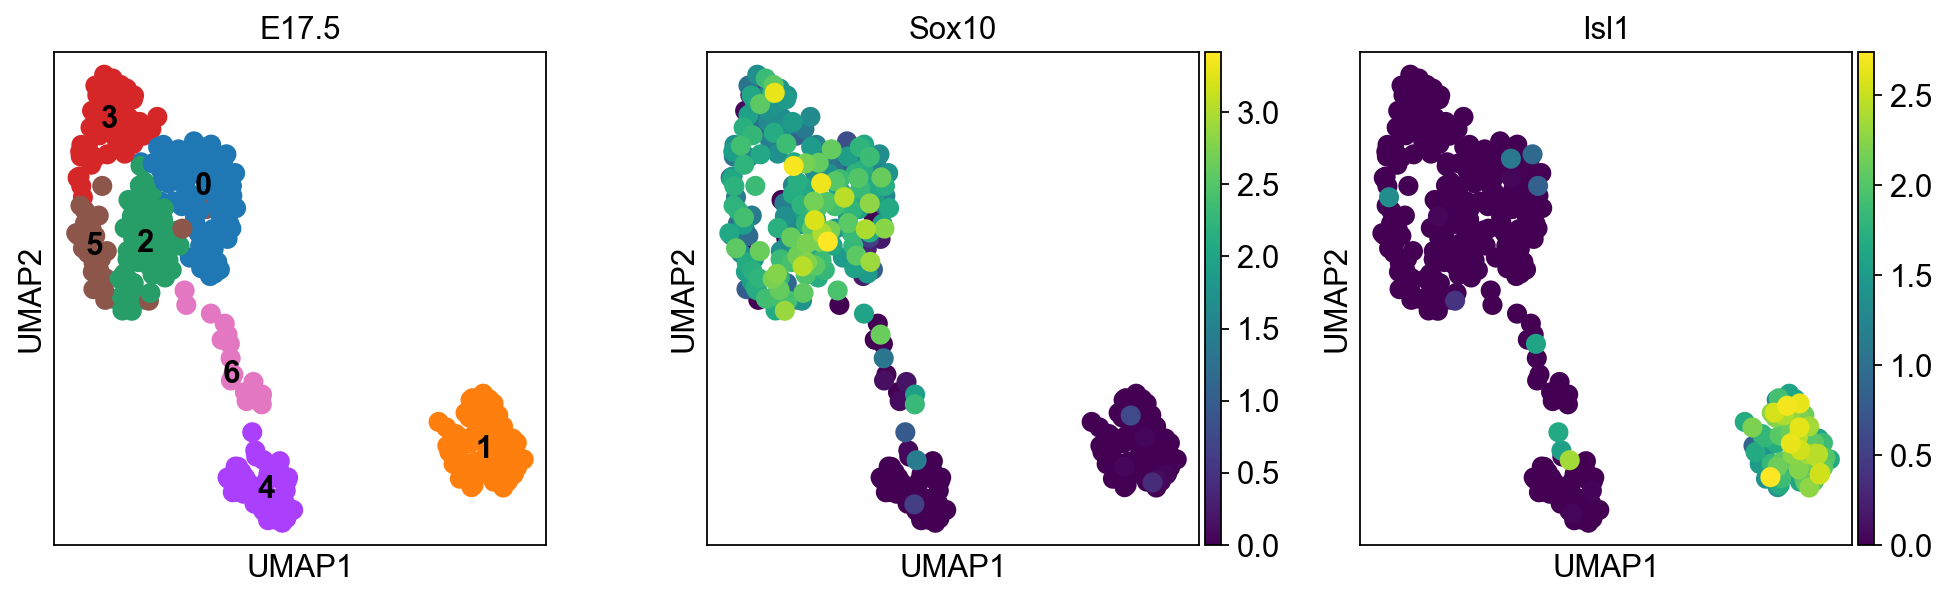

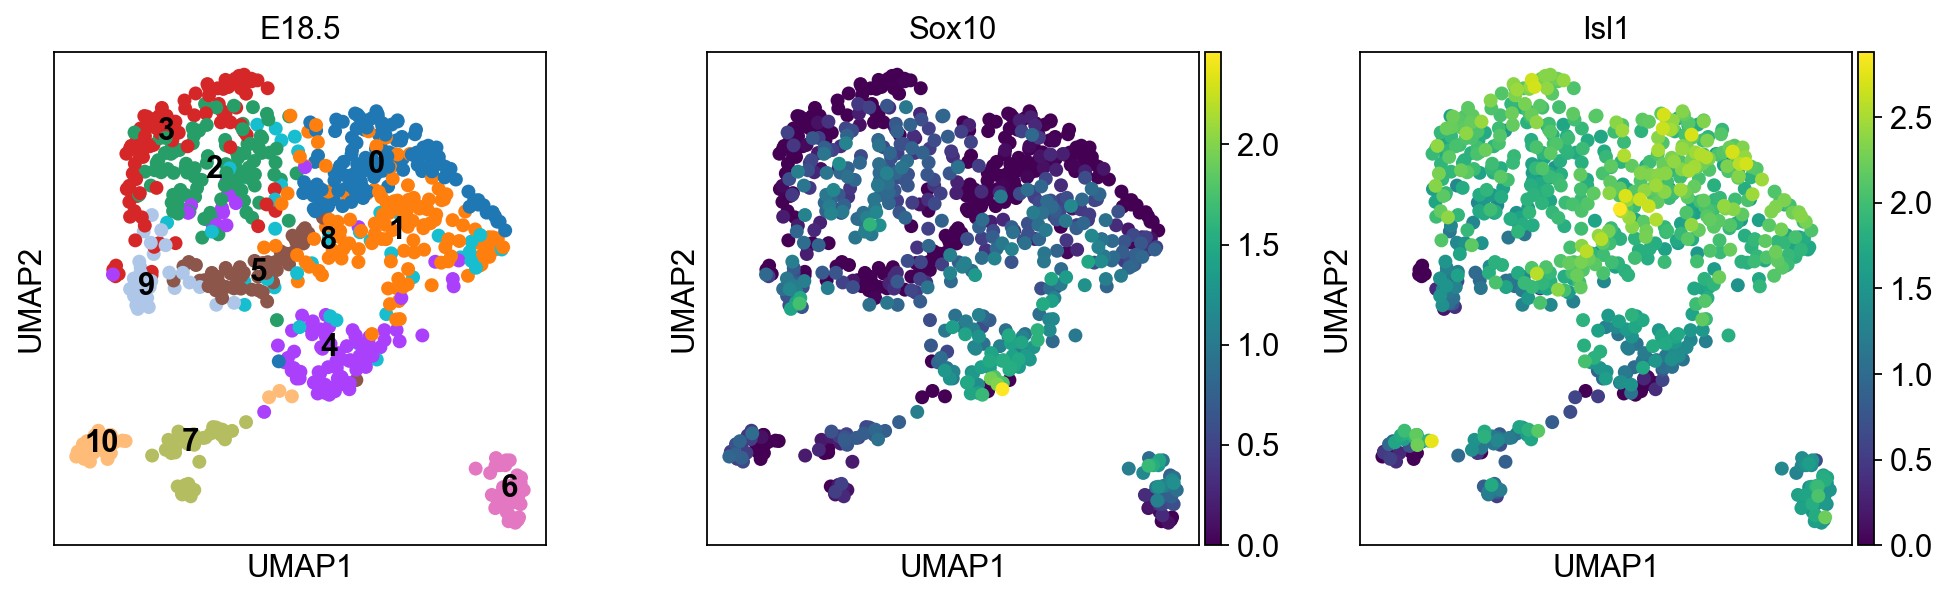

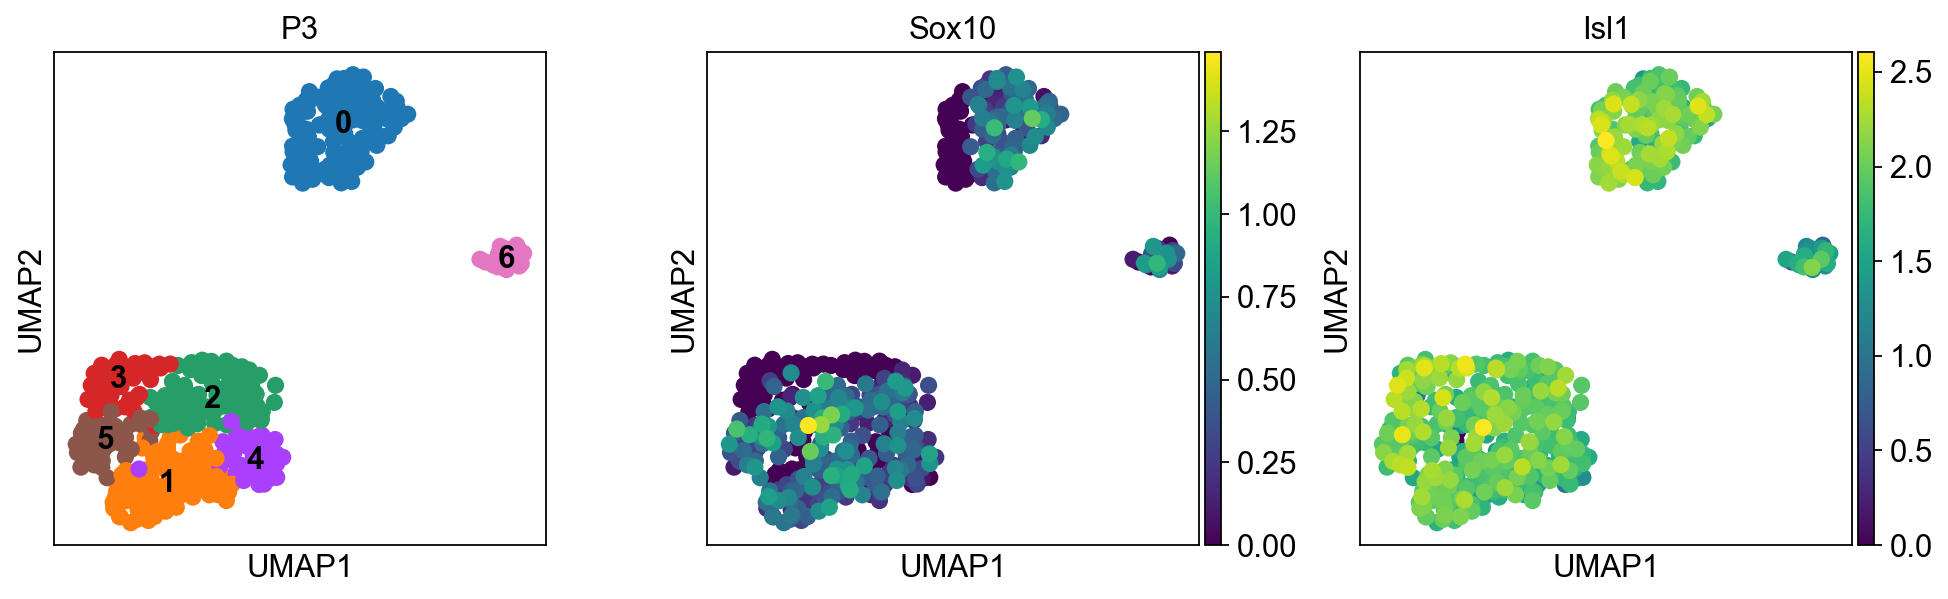

In [25]:
for devtime,adata_d in adatas.items():
    sc.pl.umap(adata_d,color=["leiden","Sox10","Isl1"],title=devtime,legend_loc="on data")

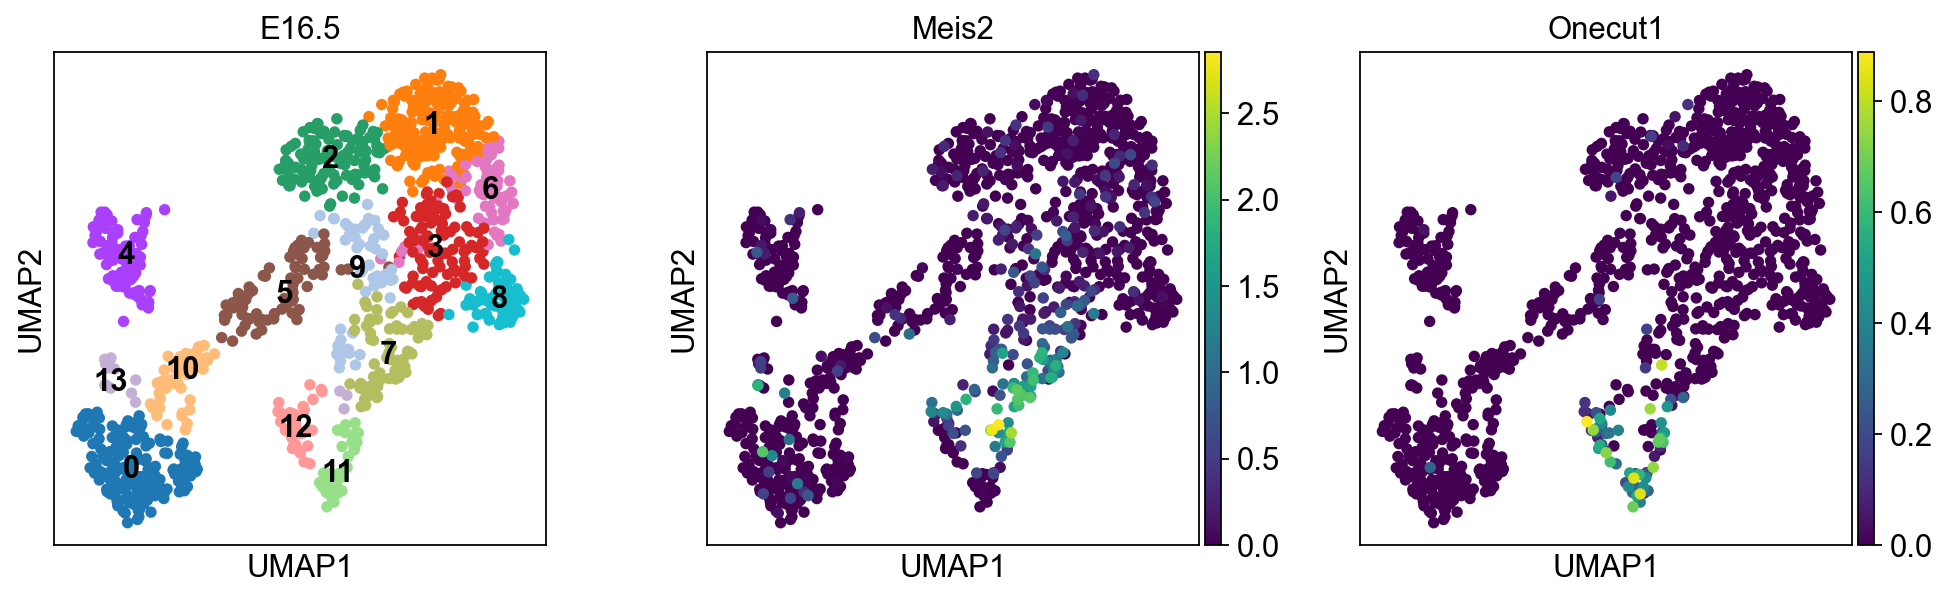

In [26]:
sc.pl.umap(adatas["E16.5"],color=["leiden","Meis2","Onecut1"],title="E16.5",legend_loc="on data")

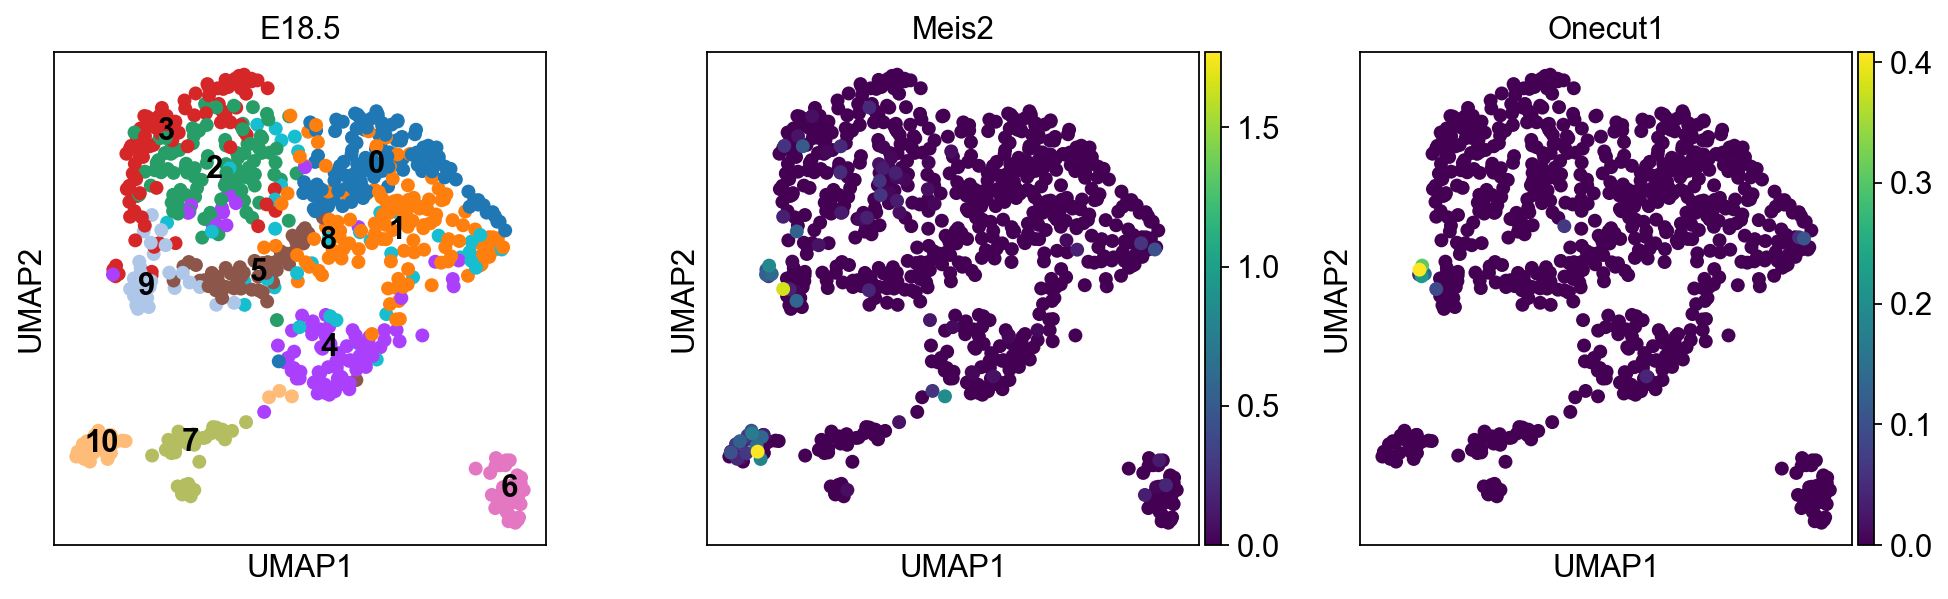

In [27]:
sc.pl.umap(adatas["E18.5"],color=["leiden","Meis2","Onecut1"],title="E18.5",legend_loc="on data")

In [28]:
c_14=adatas["E14.5"].obs_names[adatas["E14.5"].obs.leiden.isin(["4","5","9","12"])]
c_p3=adatas["P3"].obs_names
c_16=adatas["E16.5"].obs_names[adatas["E16.5"].obs.leiden.isin(["1","2","3","6","4","8","13","9"])]
c_18=adatas["E18.5"].obs_names[~adatas["E18.5"].obs.leiden2.isin(["4"])]
c_17=adatas["E17.5"].obs_names[adatas["E17.5"].obs.leiden=="1"]
c_15=adatas["E15.5"].obs_names[adatas["E15.5"].obs.leiden.isin(["2","6","4"])]

## Final dataset generation

In [29]:
import numpy as np
tokeep=np.concatenate([c_14,c_p3,c_16,c_18,c_17,c_15])

In [30]:
adata=adata[tokeep]
adata=adata[:,~adata.var_names.isin(glial_code)]

In [31]:
adata.write("data/adata_cleaned.h5ad")